## HW6 Temperature Prediction 2

**Author:** Alvin B. Lin\
**Date:** 07/10/2025\
**HW Number:** 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import re 
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score

Importing necessary packages for the analysis.

In [2]:
# --- CELL 1: 數據常量和定義 ---

LON_START = 120.00
LAT_START = 21.88
RESOLUTION = 0.03
LON_COUNT = 67
LAT_COUNT = 120
TOTAL_POINTS = LON_COUNT * LAT_COUNT 
INVALID_VALUE = -999.0
XML_FILE_PATH = "C:\\Users\\benny\\Documents\\ML\\HW6\\temp_data.xml"

Locate the file for the further reading.

In [3]:
# --- CELL 2: 數據讀取與解析函數 ---

def read_and_parse_xml(file_path):
    """
    Reads the XML file and extracts temperature data.
    """
    print("--- DATA LOADING AND COORDINATE GENERATION ---")
    GRID_LAT_SIZE = LAT_COUNT
    GRID_LON_SIZE = LON_COUNT
    
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        content_element = next((elem for elem in root.iter() if elem.tag.lower().endswith('content')), None)

        if content_element is None or content_element.text is None:
            raise ValueError("Could not find Content element or it is empty.")

        content_str = content_element.text
        number_strings = re.findall(r'[-+]?\d*\.?\d+(?:[Ee][-+]?\d+)?', content_str)
        values = np.array([float(x) for x in number_strings if x], dtype=np.float64)

        expected_count = GRID_LAT_SIZE * GRID_LON_SIZE
        if values.size != expected_count:
            raise ValueError(f"Parsed {values.size} numeric values but expected {expected_count}")

        grid = values.reshape((GRID_LAT_SIZE, GRID_LON_SIZE))

        print(f"Data loaded successfully. Grid shape: {grid.shape}")
        return grid

    except FileNotFoundError:
        print(f"Error: XML file not found at {file_path}.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"XML Parsing or Data Processing Failed: {e}", file=sys.stderr)
        return None

def create_classification_dataset(temp_grid):
    """
    Converts the temperature grid into the classification dataset: (Longitude, Latitude, label).
    """
    print("\n--- CLASSIFICATION DATASET CREATION ---")
    lat_count, lon_count = temp_grid.shape
    
    lon_coords = LON_START + np.arange(lon_count) * RESOLUTION
    lat_coords = LAT_START + np.arange(lat_count) * RESOLUTION
    
    Lon_grid, Lat_grid = np.meshgrid(lon_coords, lat_coords)
    X = np.vstack([Lon_grid.ravel(), Lat_grid.ravel()]).T
    
    Y = (temp_grid.ravel() != INVALID_VALUE).astype(int)
    
    print(f"Classification features (X) shape: {X.shape}")
    print(f"Valid points (Y=1): {np.sum(Y)}, Invalid points (Y=0): {np.sum(Y==0)}")
    return X, Y

Define a function to read the file.

In [4]:
# --- CELL 3: LDA 和 QDA 類別定義 (GDA 變體) ---

class LinearDiscriminantAnalysis:
    """Implements LDA (GDA with shared covariance), representing the initial "failed" model."""
    def __init__(self):
        self.phi = 0.0
        self.mu0 = None
        self.mu1 = None
        self.sigma_inv = None
        self.discriminant_weights = None
        self.discriminant_bias = None

    def fit(self, X, Y):
        m = X.shape[0] 
        Y0 = X[Y == 0] 
        Y1 = X[Y == 1]
        m1 = Y1.shape[0]
        self.phi = m1 / m
        self.mu0 = np.mean(Y0, axis=0)
        self.mu1 = np.mean(Y1, axis=0)
        
        Sigma0 = (Y0 - self.mu0).T @ (Y0 - self.mu0)
        Sigma1 = (Y1 - self.mu1).T @ (Y1 - self.mu1)
        sigma = (Sigma0 + Sigma1) / m
        sigma += np.eye(sigma.shape[0]) * 1e-6 
        self.sigma_inv = np.linalg.inv(sigma)
        
        self.discriminant_weights = self.sigma_inv @ (self.mu1 - self.mu0)
        self.discriminant_bias = 0.5 * (self.mu0.T @ self.sigma_inv @ self.mu0 - self.mu1.T @ self.sigma_inv @ self.mu1) + np.log(self.phi / (1 - self.phi))
        
    def predict_proba(self, X):
        score = X @ self.discriminant_weights + self.discriminant_bias
        return 1 / (1 + np.exp(-score))

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    def calculate_accuracy(self, X, Y_true, threshold=0.5):
        return accuracy_score(Y_true, self.predict(X, threshold))

class QuadraticDiscriminantAnalysis:
    """Implements QDA (GDA with separate covariance matrices) - The optimized model."""
    def __init__(self):
        self.phi = 0.0
        self.mu0 = None
        self.mu1 = None
        self.sigma0_inv = None
        self.sigma1_inv = None
        self.sigma0_det = None
        self.sigma1_det = None

    def fit(self, X, Y):
        m = X.shape[0]
        Y0 = X[Y == 0] 
        Y1 = X[Y == 1]
        m0 = Y0.shape[0]
        m1 = Y1.shape[0]
        self.phi = m1 / m
        self.mu0 = np.mean(Y0, axis=0)
        self.mu1 = np.mean(Y1, axis=0)

        Sigma0 = (Y0 - self.mu0).T @ (Y0 - self.mu0) / m0
        Sigma1 = (Y1 - self.mu1).T @ (Y1 - self.mu1) / m1
        
        Sigma0 += np.eye(Sigma0.shape[0]) * 1e-6
        Sigma1 += np.eye(Sigma1.shape[0]) * 1e-6

        self.sigma0_inv = np.linalg.inv(Sigma0)
        self.sigma1_inv = np.linalg.inv(Sigma1)
        self.sigma0_det = np.linalg.det(Sigma0)
        self.sigma1_det = np.linalg.det(Sigma1)

    def predict_proba(self, X):
        diff0 = X - self.mu0
        log_likelihood0 = -0.5 * np.log(self.sigma0_det) - 0.5 * np.sum(diff0 @ self.sigma0_inv * diff0, axis=1)
        
        diff1 = X - self.mu1
        log_likelihood1 = -0.5 * np.log(self.sigma1_det) - 0.5 * np.sum(diff1 @ self.sigma1_inv * diff1, axis=1)
        
        log_joint0 = log_likelihood0 + np.log(1 - self.phi)
        log_joint1 = log_likelihood1 + np.log(self.phi)
        
        return 1 / (1 + np.exp(log_joint0 - log_joint1))

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    def calculate_accuracy(self, X, Y_true, threshold=0.5):
        return accuracy_score(Y_true, self.predict(X, threshold))

Define the *class* for both **GDA** and **QDA**.

In [5]:
# --- CELL 4: 邏輯迴歸類別定義 (Loss Curve 專用) ---

class LogisticRegressionGD:
    """Implements Logistic Regression using Gradient Descent."""
    def __init__(self, learning_rate=0.1, n_iterations=500):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.val_loss_history = [] # 新增：用於儲存驗證集 Loss

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500) 
        return 1.0 / (1.0 + np.exp(-z))

    def _loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        # Binary Cross-Entropy (Log Loss)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    # 更新 fit 函式，接受訓練集 (X_train, Y_train) 和 驗證集 (X_val, Y_val)
    def fit(self, X_train, Y_train, X_val=None, Y_val=None):
        n_samples, n_features = X_train.shape
        self.weights = np.zeros(n_features) * 1e-3
        self.bias = 0
        self.loss_history = []
        self.val_loss_history = []

        for i in range(self.n_iterations):
            # 1. 訓練集 Loss 計算和梯度下降
            z_train = np.dot(X_train, self.weights) + self.bias
            y_pred_train = self._sigmoid(z_train)

            current_train_loss = self._loss(Y_train, y_pred_train)
            self.loss_history.append(current_train_loss)
            
            # 2. 驗證集 Loss 計算 (如果提供了驗證集)
            if X_val is not None and Y_val is not None:
                z_val = np.dot(X_val, self.weights) + self.bias
                y_pred_val = self._sigmoid(z_val)
                current_val_loss = self._loss(Y_val, y_pred_val)
                self.val_loss_history.append(current_val_loss)
            
            # 3. 梯度更新 (僅基於訓練集)
            dw = (1 / n_samples) * np.dot(X_train.T, (y_pred_train - Y_train))
            db = (1 / n_samples) * np.sum(y_pred_train - Y_train)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # 4. 打印 Loss 進度
            if (i + 1) % (self.n_iterations // 5 or 1) == 0:
                val_loss_msg = f", Test Loss: {current_val_loss:.6f}" if X_val is not None else ""
                print(f"  LR Iteration {i+1}/{self.n_iterations}, Training Loss: {current_train_loss:.6f}{val_loss_msg}")

    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def calculate_accuracy(self, X, Y_true, threshold=0.5):
        return accuracy_score(Y_true, self.predict(X, threshold))

Writing a function to calculate the loss curve for the validation loss and the test loss.

In [6]:
# --- CELL 5: 視覺化工具函數 ---

def plot_confusion_matrix(Y_true, Y_pred, model_name, threshold):
    """Plots the confusion matrix using matplotlib."""
    
    cm = confusion_matrix(Y_true, Y_pred)
    
    plt.figure(figsize=(6, 6))
    # 使用 matshow 繪製矩陣為熱力圖
    plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
    plt.title(f'Confusion Matrix - {model_name} (Thr={threshold:.4f})', y=1.1)
    plt.colorbar()
    
    tick_marks = np.arange(2)
    # 標籤 0 代表 'Invalid'，1 代表 'Valid'
    plt.xticks(tick_marks, ['Invalid (0)', 'Valid (1)'])
    plt.yticks(tick_marks, ['Invalid (0)', 'Valid (1)'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # 在每個單元格中添加數值
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # 根據顏色深淺選擇文字顏色以保持可讀性
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black",
                     fontsize=14)

    plt.show()

    
# 更新 plot_loss_curve 函式，接受兩組 Loss 歷史記錄
def plot_loss_curve(train_loss_history, val_loss_history=None, title="Logistic Regression Training Loss"):
    """Plots the training and optionally validation loss history with log scale on the Y-axis."""
    plt.figure(figsize=(10, 6))
    
    iterations = range(1, len(train_loss_history) + 1)
    
    plt.plot(iterations, train_loss_history, label='Training Loss (BCE)', color='blue', linewidth=2)
    
    if val_loss_history is not None and len(val_loss_history) > 0:
        plt.plot(iterations, val_loss_history, label='Validation/Test Loss (BCE)', color='red', linestyle='--', linewidth=2)
        
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss (Log Scale)')
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()
    plt.show()

def plot_confusion_visualization(model, X_test, Y_test, X_class, threshold, title_suffix):
    """
    Plots the decision boundary and visualizes TP/FP/FN/TN for a given model
    with a specific threshold.
    """
    Y_pred = model.predict(X_test, threshold=threshold)

    TP_mask = (Y_test == 1) & (Y_pred == 1)
    TN_mask = (Y_test == 0) & (Y_pred == 0)
    FP_mask = (Y_test == 0) & (Y_pred == 1)
    FN_mask = (Y_test == 1) & (Y_pred == 0)

    x_min, x_max = X_class[:, 0].min() - 0.05, X_class[:, 0].max() + 0.05
    y_min, y_max = X_class[:, 1].min() - 0.05, X_class[:, 1].max() + 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    X_grid = np.c_[xx.ravel(), yy.ravel()]
    
    Z_gda = model.predict(X_grid, threshold=threshold)
    Z_gda = Z_gda.reshape(xx.shape)

    plt.figure(figsize=(12, 9))

    plt.contourf(xx, yy, Z_gda, alpha=0.3, levels=[-0.5, 0.5, 1.5], colors=['#F5C2C7', '#C2F5F0'])
    plt.contour(xx, yy, Z_gda, levels=[0.5], colors='black', linestyles='-', linewidths=2)

    # Plot the four confusion matrix categories
    plt.scatter(X_test[TP_mask, 0], X_test[TP_mask, 1], color='#1b9e77', marker='o', s=40, edgecolor='white', label=f'TP: Valid & Predicted Valid ({np.sum(TP_mask)})')
    plt.scatter(X_test[TN_mask, 0], X_test[TN_mask, 1], color='#7570b3', marker='s', s=40, edgecolor='white', label=f'TN: Invalid & Predicted Invalid ({np.sum(TN_mask)})')
    plt.scatter(X_test[FP_mask, 0], X_test[FP_mask, 1], color='#d95f02', marker='^', s=50, edgecolor='black', label=f'FP: Invalid but Predicted Valid ({np.sum(FP_mask)})')
    plt.scatter(X_test[FN_mask, 0], X_test[FN_mask, 1], color='#e7298a', marker='X', s=50, edgecolor='black', label=f'FN: Valid but Predicted Invalid ({np.sum(FN_mask)})')

    
    plt.title(f'{title_suffix} (Threshold={threshold:.4f})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='lower left', scatterpoints=1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_roc_and_find_optimal_threshold(model, X_test, Y_test, model_name):
    """Calculates, plots ROC curve, and finds the optimal threshold using Youden's J Index."""
    
    Y_probs = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)
    roc_auc = auc(fpr, tpr)
    
    J = tpr - fpr
    optimal_index = np.argmax(J)
    optimal_threshold = thresholds[optimal_index]
    
    print(f"\n--- ROC ANALYSIS FOR {model_name} ---")
    print(f"AUC (Area Under Curve): {roc_auc:.4f}")
    print(f"Optimal Threshold (Youden's J Index): {optimal_threshold:.4f}")

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.plot(fpr[optimal_index], tpr[optimal_index], 'o', color='red', markersize=10, label=f'Optimal Point (Thr={optimal_threshold:.4f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return optimal_threshold

The function is created for the loss curve drawing.

In [7]:
# --- CELL 6: 主執行邏輯（數據準備） ---

# 1. Read and Prepare Data 
temp_grid = read_and_parse_xml(XML_FILE_PATH)

if temp_grid is None:
    # If data loading fails, stop execution
    sys.exit()

X_class, Y_class = create_classification_dataset(temp_grid)

# 2. Data Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_class, Y_class, test_size=0.3, random_state=42, stratify=Y_class
)
print(f"\nData split: Train {X_train.shape[0]} points, Test {X_test.shape[0]} points.")

--- DATA LOADING AND COORDINATE GENERATION ---
Data loaded successfully. Grid shape: (120, 67)

--- CLASSIFICATION DATASET CREATION ---
Classification features (X) shape: (8040, 2)
Valid points (Y=1): 3495, Invalid points (Y=0): 4545

Data split: Train 5628 points, Test 2412 points.


All the data are read and classified into testing and validation sets.


PHASE 1: INITIAL GDA ATTEMPT (Linear Discriminant Analysis)
LDA Test Accuracy (Threshold 0.5000): 0.5158


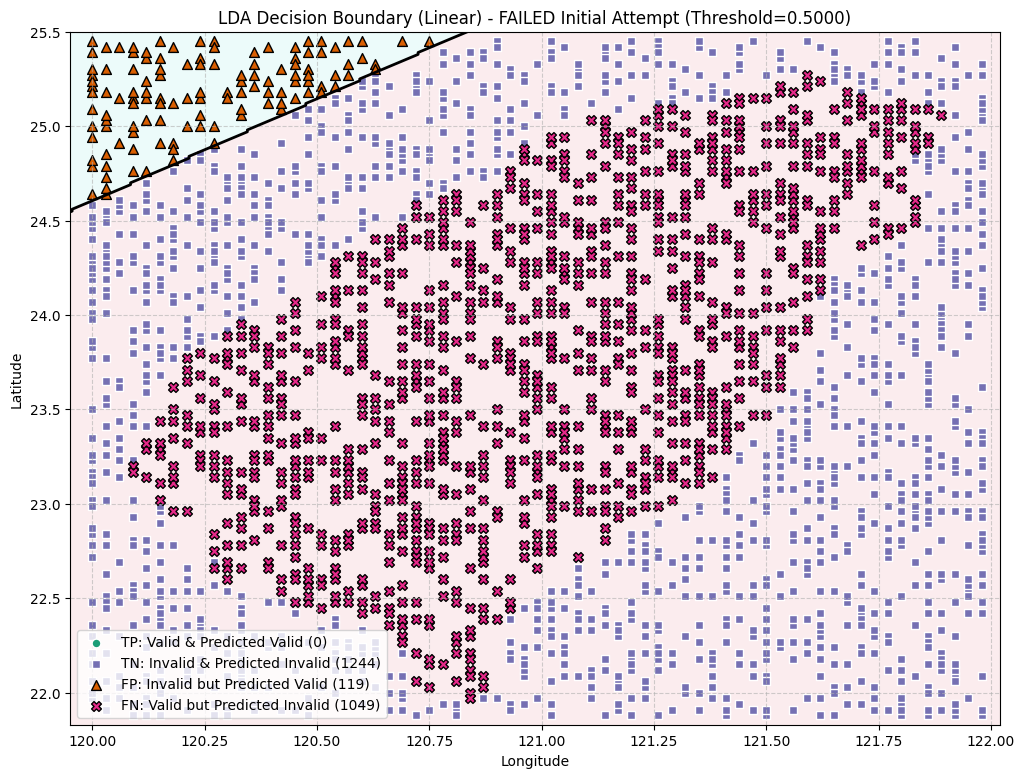

In [8]:
# --- CELL 7: PHASE 1: INITIAL ATTEMPT (LDA/Linear GDA) ---

print("\n" + "="*50)
print("PHASE 1: INITIAL GDA ATTEMPT (Linear Discriminant Analysis)")
print("="*50)

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, Y_train)
lda_default_accuracy = lda_model.calculate_accuracy(X_test, Y_test, threshold=0.5)
print(f"LDA Test Accuracy (Threshold 0.5000): {lda_default_accuracy:.4f}")

# Plot the poor performing LDA model
plot_confusion_visualization(lda_model, X_test, Y_test, X_class, 0.5, 
                             "LDA Decision Boundary (Linear) - FAILED Initial Attempt")

This is the result for the **GDA**, which gives the linear boundary. The performance is not good based on the model selection; it is assumed that two classes (`y` = 1 and `y` = 0) to have the same discrimination matrices, but in reality, it is not ture.

In [9]:
# --- CELL 8: PHASE 2: OPTIMIZED MODEL (QDA) - Default Threshold ---

print("\n" + "="*50)
print("PHASE 2: OPTIMIZED GDA (Quadratic Discriminant Analysis - QDA)")
print("="*50)

qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, Y_train)


PHASE 2: OPTIMIZED GDA (Quadratic Discriminant Analysis - QDA)



--- ROC ANALYSIS FOR QDA ---
AUC (Area Under Curve): 0.9420
Optimal Threshold (Youden's J Index): 0.3910


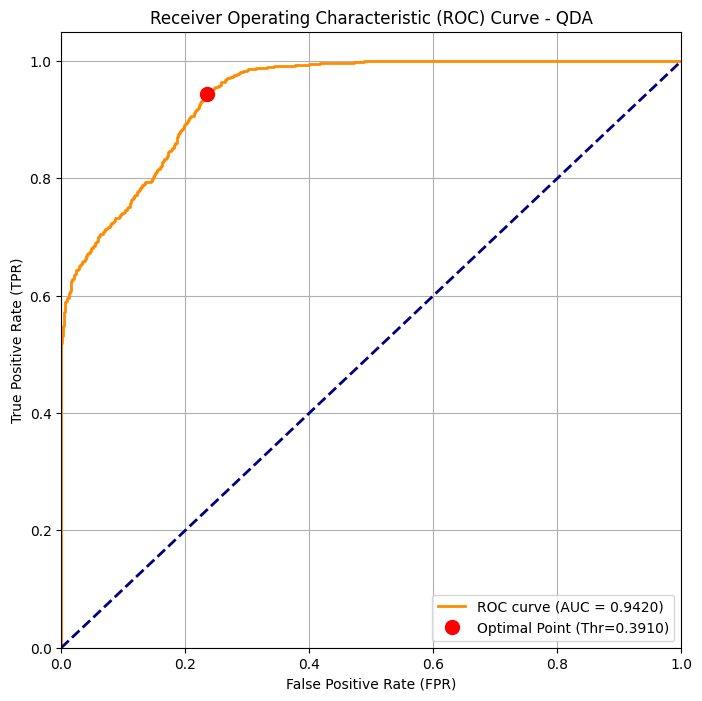


QDA Performance with Optimal Threshold (0.3910)
New Test Accuracy: 0.8425
Precision: 0.7551
Recall: 0.9438
F1-Score: 0.8390


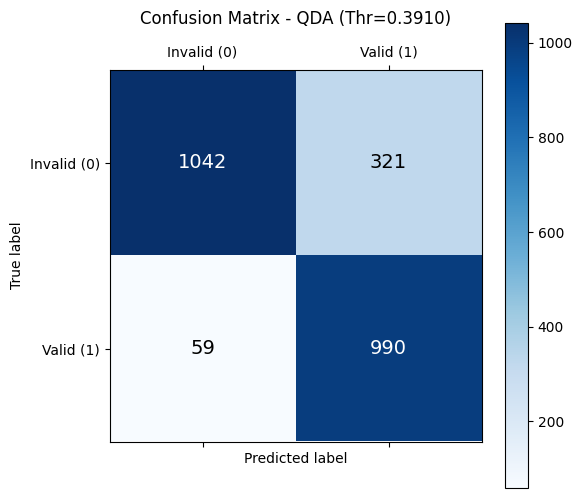

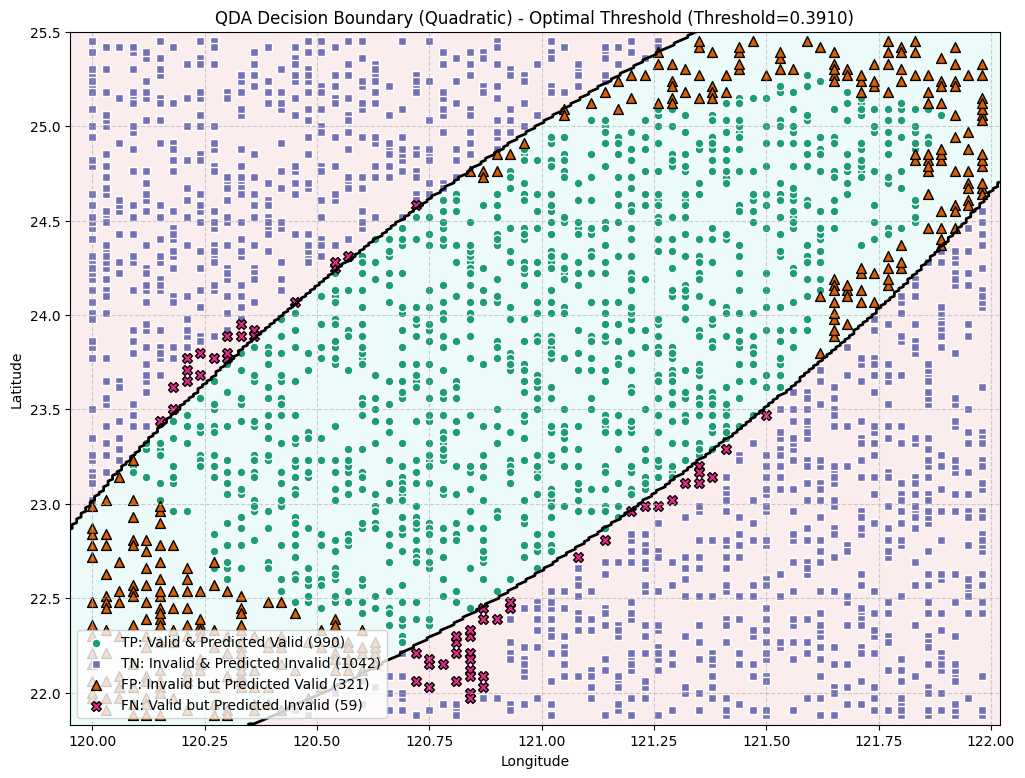

In [10]:
# --- CELL 9: PHASE 2: OPTIMIZED MODEL (QDA) - ROC Analysis ---

# ROC Analysis and Optimal Threshold finding
optimal_threshold = plot_roc_and_find_optimal_threshold(qda_model, X_test, Y_test, "QDA")

# Evaluate with Optimal Threshold
qda_optimal_accuracy = qda_model.calculate_accuracy(X_test, Y_test, threshold=optimal_threshold)
print("\n" + "="*40)
print(f"QDA Performance with Optimal Threshold ({optimal_threshold:.4f})")
print(f"New Test Accuracy: {qda_optimal_accuracy:.4f}")

# 計算並輸出 Precision, Recall 和 F1-Score
Y_pred_optimal = qda_model.predict(X_test, threshold=optimal_threshold)
qda_precision = precision_score(Y_test, Y_pred_optimal)
qda_recall = recall_score(Y_test, Y_pred_optimal)
qda_f1 = f1_score(Y_test, Y_pred_optimal)

print(f"Precision: {qda_precision:.4f}")
print(f"Recall: {qda_recall:.4f}")
print(f"F1-Score: {qda_f1:.4f}")
print("="*40)

# 繪製混淆矩陣
plot_confusion_matrix(Y_test, Y_pred_optimal, "QDA", optimal_threshold)

# Plot QDA Results with optimal threshold
plot_confusion_visualization(qda_model, X_test, Y_test, X_class, optimal_threshold, 
                             "QDA Decision Boundary (Quadratic) - Optimal Threshold")

The result of the **GDA classification** and the **ROC Analysis** are shown above, the *threshold* is selected as 0.3910, detemined by *Youden index*, resulting precision 0.8425.


PHASE 3: LOGISTIC REGRESSION (For Loss Curve Demo)

Starting Logistic Regression Training (Iterative Model)...
  LR Iteration 100/500, Training Loss: 0.681581, Test Loss: 0.682840
  LR Iteration 200/500, Training Loss: 0.681493, Test Loss: 0.682834
  LR Iteration 300/500, Training Loss: 0.681492, Test Loss: 0.682841
  LR Iteration 400/500, Training Loss: 0.681492, Test Loss: 0.682842
  LR Iteration 500/500, Training Loss: 0.681492, Test Loss: 0.682842


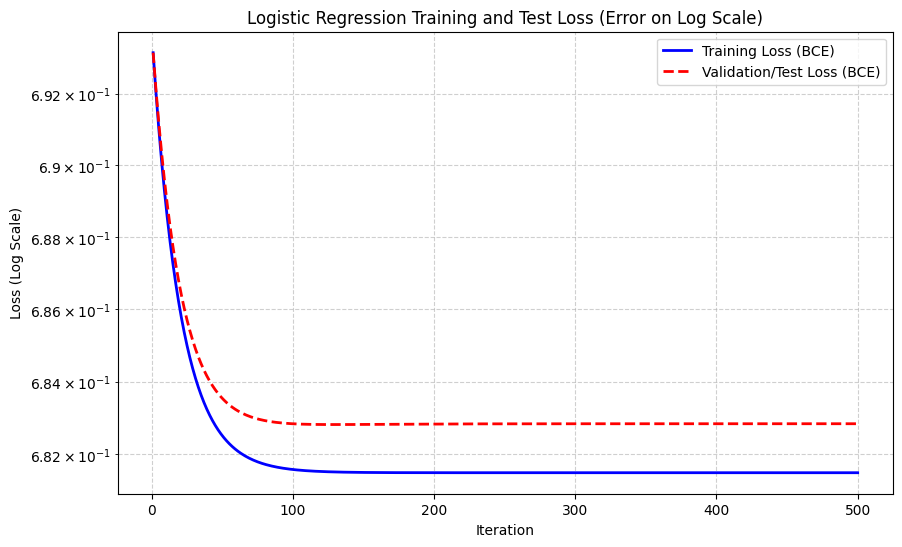

In [12]:
# --- CELL 10: PHASE 3: LOGISTIC REGRESSION (Loss Curve Demo) ---

print("\n" + "="*50)
print("PHASE 3: LOGISTIC REGRESSION (For Loss Curve Demo)")
print("="*50)

# 1. Standardize features for stable Gradient Descent
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_std[X_std == 0] = 1.0 

X_train_scaled = (X_train - X_mean) / X_std
# 2. 確保測試集使用訓練集的平均值和標準差進行標準化
X_test_scaled = (X_test - X_mean) / X_std 

lr_model = LogisticRegressionGD(learning_rate=0.1, n_iterations=500)

print("\nStarting Logistic Regression Training (Iterative Model)...")
# 3. 將訓練集和測試集都傳遞給 fit 函式
lr_model.fit(X_train_scaled, Y_train, X_test_scaled, Y_test)

# Plot the requested loss curve (Y-axis in Log Scale)
# 4. 傳遞兩組 Loss 歷史記錄以繪製兩條曲線
plot_loss_curve(lr_model.loss_history, lr_model.val_loss_history,
                title="Logistic Regression Training and Test Loss (Error on Log Scale)")